<h1><center><font color = 'blue'>AMSUA N18 CH14 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua12_n18_ch14.h5')
print(len(df))

1447004


### Compute Sensitivity

In [3]:
df['SENSITIVITY'] = df['IMPACT']/df['OMF']

### Remove outliers

In [4]:
y_mean = df['SENSITIVITY'].mean()
y_std = df['SENSITIVITY'].std()

df['is_outlier'] = df['SENSITIVITY'].map(lambda x: abs((x - y_mean)) > 3 * y_std)

non_outliers = df[df['is_outlier'] == False].reset_index(drop=True)

print(len(non_outliers))

1422170


### Split ML inputs and outputs

In [5]:
X = non_outliers.drop(['DATETIME', 'IMPACT', 'OMF', 'SENSITIVITY', 'is_outlier'], axis=1)
y = non_outliers['SENSITIVITY']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [6]:
y.describe()

count    1.422170e+06
mean     8.544832e-11
std      5.503388e-07
min     -2.000073e-06
25%     -2.907608e-07
50%      4.214112e-09
75%      2.934565e-07
max      1.997934e-06
Name: SENSITIVITY, dtype: float64

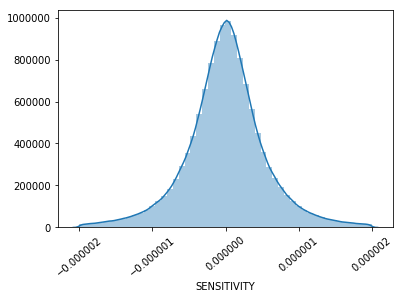

In [7]:
sns.distplot(y)
plt.xticks(rotation=40)
plt.show()

In [8]:
abs(y).describe()

count    1.422170e+06
mean     4.039914e-07
std      3.737160e-07
min      4.867192e-13
25%      1.311426e-07
50%      2.921281e-07
75%      5.577333e-07
max      2.000073e-06
Name: SENSITIVITY, dtype: float64

### y correlations with X variables 

In [9]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
v_427.673    0.024159
v_390.897    0.023375
v_464.421    0.023266
v_501.148    0.022592
v_537.86     0.021932
dtype: float64

5 smallest corr with y:
sphu_0.14    -0.021818
lon          -0.021717
LONGITUDE    -0.021716
sphu_0.706   -0.021665
sphu_0.105   -0.021611
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [10]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [11]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [13]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [14]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

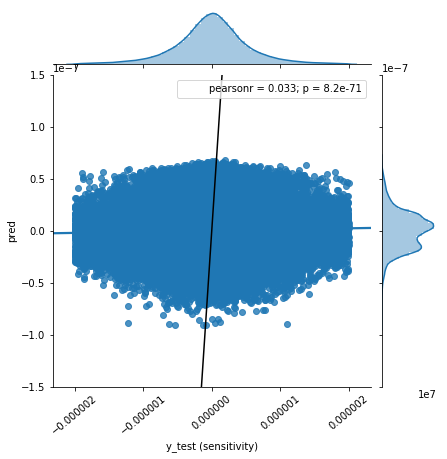

In [26]:
ax = sns.jointplot(x=y_test , y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.00000015, 0.00000015)
# add bissectrice (in black)
plt.plot([-0.0000015, 0.0000015], [-0.0000015, 0.0000015], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Gradient Boosting

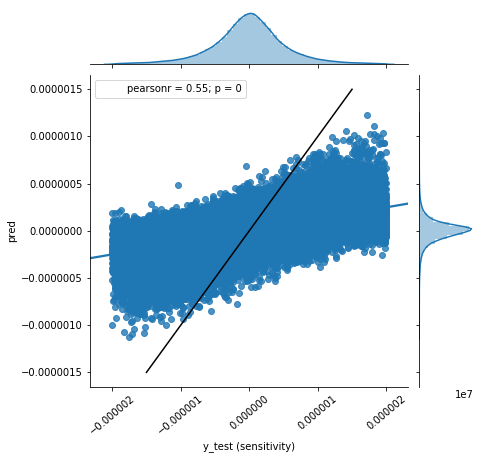

In [16]:
ax = sns.jointplot(x=y_test , y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.0000015, 0.0000015], [-0.0000015, 0.0000015], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Mean Squared Error

In [17]:
print('Only zeros MSE: {0:.4g}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('AMSUA LR MSE:   {0:.4g}' .format(mean_squared_error(y_test, lr_pred)))
print('AMSUA GBM MSE:  {0:.4g}' .format(mean_squared_error(y_test, gbm_pred)))

Only zeros MSE: 3.019e-13
AMSUA LR MSE:   3.015e-13
AMSUA GBM MSE:  2.423e-13


#### Compute statistics about real sensitivity and pred sensitivity ratio

In [18]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count    2.844340e+05
mean    -5.895208e+00
std      9.052336e+03
min     -2.999940e+06
25%     -1.964490e+00
50%      2.162057e+00
75%      6.580946e+00
max      2.787174e+06
Name: SENSITIVITY, dtype: float64

#### Display ratio pdf

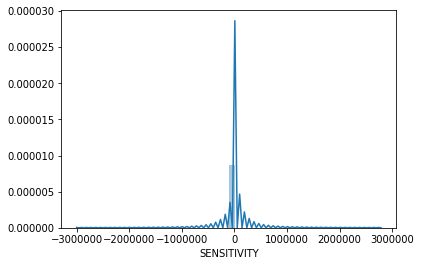

In [19]:
ax = sns.distplot(ratio, norm_hist=True)

#### % of ratio values between ]-5:5[

In [20]:
print('{0:.2f}%' .format(len(ratio[(ratio > -5) & (ratio < 5)])/len(ratio)*100))

51.37%


#### Display ratio between ]-5:5[ pdf

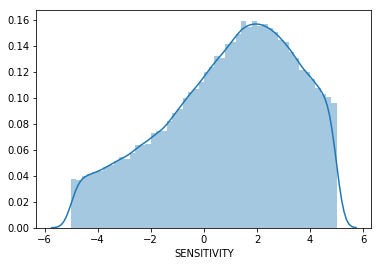

In [21]:
filtered = ratio[(ratio > -5) & (ratio < 5)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [22]:
print('{0:.2f}%' .format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

7.30%


#### % of ratio negative sign

In [23]:
print('{0:.2f}%' .format(len(ratio[ratio < 0])/len(ratio)*100))

34.19%


#### % of ratio values ≈ 0

In [24]:
print('{0:.2f}%' .format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.01%
